## 1. Load Data

#### 1.1 Import images

In [1]:
from scripts.deepgtav.messages import frame2numpy
import numpy as np
import pickle
import gzip
import os
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

filepath = os.path.join(os.getcwd(), 'data')
filename = "dataset.pz"
pfile = gzip.open(os.path.join(filepath, filename), mode='rb')

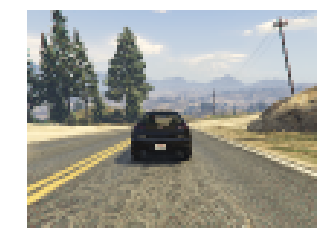

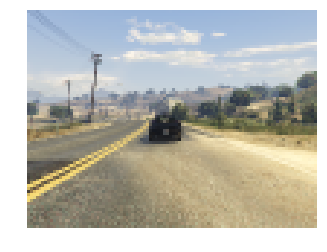

In [2]:
count = 0
no_of_channels = 3

frames_per_weather = 20000
reps_per_weather = 8
frames_per_rep = int(frames_per_weather/reps_per_weather)
image_size = (200,150)

x = []
y = []

while True:
    try:
        
        # Load var from pickle
        var = pickle.load(pfile)
        
        # Skip first n frames
        count += 1
        # if count<3000: continue
            
        # Save image and steering
        image = frame2numpy(var['frame'], image_size)
        image = cv2.resize(image, (100,75))
        x.append(image)
        y.append([var['steering'], var['throttle'], var['brake']])
        
        # Display image
        if count % 1000 == 0:
            plt.imshow(image[:,:,::-1])
            plt.axis('off')
            plt.show()
        
        if count>2000: break
            
    except EOFError: break

In [3]:
# Convert to numpy
x = np.array(x)
y = np.array(y)
print('Dataset Shape', x.shape, y.shape)

Dataset Shape (2001, 75, 100, 3) (2001, 3)


## 2. Preprocess Data

#### 2.1 Normalize images to [-1,1]

In [4]:
print(np.min(x), np.max(x))
x = (x/255 - 0.5) * 2
np.min(x), np.max(x)

14 255


(-0.8901960784313725, 1.0)

In [5]:
np.min(y), np.max(y)

(-0.38307901431646607, 1.0)

#### 2.4 Split data for train and test

In [6]:
seed = 1
np.random.seed(seed)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=np.random)
print("Train Data | Test Data")
print(("{0:^10} | {1:^10}").format(x_train.shape[0], x_test.shape[0]))

Train Data | Test Data
   1600    |    401    


## 3. Build Model

#### 3.1 Import Keras and use NCHW mode

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.utils import np_utils

from keras import backend
backend.set_image_dim_ordering('tf')

Using TensorFlow backend.


#### 3.2 Create reusable functions

In [8]:
c = x.shape[3]
h = x.shape[1]
w = x.shape[2]
no_of_classes = y.shape[1]
print(x.shape, y.shape)

def evaluate_model(model):
    print("\n\n")
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: ", scores[1]*100, "%")
    return scores

(2001, 75, 100, 3) (2001, 3)


#### 3.3 Create a baseline model

In [ ]:
def baseline_model():
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), kernel_initializer='normal', activation='relu', input_shape=(h, w, c)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(Conv2D(256, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(Conv2D(256, (3, 3), kernel_initializer='normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(Conv2D(512, (3, 3), kernel_initializer='normal', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2048, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_of_classes, kernel_initializer='normal', activation='tanh'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

model = baseline_model()
model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=125)
evaluate_model(model)

Train on 1440 samples, validate on 160 samples
Epoch 1/10


## 4. Saving and loading model architecture and weights

#### 4.1 Define reusable functions

In [16]:
import h5py
from keras.models import model_from_json
from keras.models import load_model

path_models = os.path.join(os.getcwd(), 'models')
valid_model_files = [".h5", ".json"]
weights_suffix = '_weights.h5'
architecture_suffix = '_architecture.json'

In [17]:
def get_last_file_number(path):
    numbers = [-1]
    for file in os.listdir(path):
        filename = os.path.splitext(file)[0]
        ext = os.path.splitext(file)[1]
        if ext.lower() not in valid_model_files: continue
        if filename.startswith('model_'): 
            numbers.append(int(''.join(list(filter(str.isdigit, filename)))))
    counter = max(numbers)
    return counter

#### 4.2 Save current model

In [18]:
counter = 0
if not os.path.isdir(path_models): os.makedirs(path_models)
else: counter = get_last_file_number(path_models) + 1

model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + weights_suffix
with open(model_arch_file, 'w+') as json_file:
    json_file.write(model.to_json(indent=4))
model.save_weights(model_weights_file)

model.save(path_models + '\\' + model_name + '.h5')

print("Saving files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

Saving files:
	model_008_architecture.json
	model_008_weights.h5


#### 4.3 Load model from file

In [21]:
counter = get_last_file_number(path_models)
    
model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + architecture_suffix

print("Loading files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

if not os.path.isfile(model_arch_file):
    print('Could not find', model_arch_file)
elif not os.path.isfile(model_weights_file):
    print('Could not find', model_weights_file)
else:
    # with open(model_arch_file, 'r') as json_file:
        # model_loaded = model_from_json(json_file.read())
    # model_loaded.load_weights(model_weights_file)
    model_loaded = load_model(path_models + '\\' + model_name + '.h5')

Loading files:
	model_008_architecture.json
	model_008_weights.h5


In [22]:
evaluate_model(model_loaded)




4992/4992 [==============================] - 2s 495us/step
Accuracy:  82.4519230769 %


[0.53564166946288871, 0.82451923076923073]